In [40]:
import torch
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import math
from scipy.stats import gaussian_kde

In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [2]:
train_df = pd.read_csv("train_full.csv")
val_df = pd.read_csv("val_full.csv")

In [3]:
train_content = train_df["text"].values
val_content = val_df["text"].values

train_views = train_df["video_views"].values
val_views = val_df["video_views"].values

train_durations = train_df["video_duration"].values
val_durations = val_df["video_duration"].values

train_users = train_df["username"].values
val_users = val_df["username"].values

train_labels = train_df["likes"].values
val_labels = val_df["likes"].values

train_hasvids = np.array(train_df["video_url_status"].values == "Link exists and is accessible")
val_hasvids = np.array(val_df["video_url_status"].values == "Link exists and is accessible")

train_hasimgs = np.array(train_df["image_url_status"].values == "Link exists and is accessible")
val_hasimgs = np.array(val_df["image_url_status"].values == "Link exists and is accessible")

train_dates = train_df['date'].values
val_dates = val_df['date'].values

In [4]:
train_hasvids,train_hasimgs,train_dates

(array([False, False, False, ..., False, False,  True]),
 array([ True,  True,  True, ...,  True,  True, False]),
 array(['2020-12-12 00:47:00', '2018-06-30 10:04:20',
        '2020-09-29 19:47:28', ..., '2019-09-07 16:18:10',
        '2020-11-11 20:18:15', '2019-10-29 10:44:00'], dtype=object))

In [5]:
val_df

,text_status,text,languages,image_url_status,image_url,video_thumbnail_status,video_thumbnail_url,video_url_status,video_url,video_bitrate,...,gif_url,gif_bitrate,year,month,day_of_year,day_of_week,date,username,inferred company,likes
0,Has text,LASU Celebrates New Dawn Of Unbroken Peace As ...,['ENGLISH'],Link exists and is accessible,https://pbs.twimg.com/media/EHo1yZyU0AIBW8N?fo...,Link does not exist,Video thumbnail does not exist,Link does not exist,Video does not exist,Does not exist,...,GIF does not exist,Does not exist,2019,October,297,Thursday,2019-10-24 10:51:03,IndependentNGR,independent,0
1,Has text,"The US-Taliban agreement, which sets into moti...",['ENGLISH'],Link does not exist,Image does not exist,Link exists and is accessible,https://pbs.twimg.com/media/ESCO6b9WkAUBI1o.jpg,Link exists and is accessible,https://video.twimg.com/amplify_video/12341434...,288000,...,GIF does not exist,Does not exist,2020,March,61,Sunday,2020-03-01 15:48:46,CNN,cnn,672
2,Has text,Many people are understandably anxious to get ...,['ENGLISH'],Link exists and is accessible,https://pbs.twimg.com/media/EdP2C8RXYAAEkdX?fo...,Link does not exist,Video thumbnail does not exist,Link does not exist,Video does not exist,Does not exist,...,GIF does not exist,Does not exist,2020,July,201,Sunday,2020-07-19 00:07:00,MayoClinic,mayo clinic,78
3,Has text,ALSO NOW (yes it's wild here today): Sen Merkl...,['ENGLISH'],Link exists and is accessible,https://pbs.twimg.com/media/DoCNXLsV4AAM2Aw?fo...,Link does not exist,Video thumbnail does not exist,Link does not exist,Video does not exist,Does not exist,...,GIF does not exist,Does not exist,2018,September,269,Wednesday,2018-09-26 16:42:17,LisaDNews,desjardins,961
4,Has text,Toyota Motor North America Chief Diversity Off...,['ENGLISH'],Link exists and is accessible,https://pbs.twimg.com/media/ES2r4X5WkAA8UuA?fo...,Link does not exist,Video thumbnail does not exist,Link does not exist,Video does not exist,Does not exist,...,GIF does not exist,Does not exist,2020,March,71,Wednesday,2020-03-11 20:15:08,ToyotaSD,toyota,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29922,Has text,Start em young 💪🏾 <hyperlink>,['Unknown'],Link does not exist,Image does not exist,Link exists and is accessible,https://pbs.twimg.com/ext_tw_video_thumb/11180...,Link exists and is accessible,https://video.twimg.com/ext_tw_video/111807579...,256000,...,GIF does not exist,Does not exist,2019,April,106,Tuesday,2019-04-16 08:57:17,SonnyBWilliams,williams,2151
29923,Has text,"Nearly 15 years after leaving public office, f...",['ENGLISH'],Link exists and is accessible,https://pbs.twimg.com/media/Dehc02rW4AAYBVQ?fo...,Link does not exist,Video thumbnail does not exist,Link does not exist,Video does not exist,Does not exist,...,GIF does not exist,Does not exist,2018,May,151,Thursday,2018-05-31 11:41:10,TheCurrentCBC,cbc,44
29924,Has text,Sparks are set to fly when speedsters Rabz Max...,['ENGLISH'],Link exists and is accessible,https://pbs.twimg.com/media/DyVHClwXcAAauD2?fo...,Link does not exist,Video thumbnail does not exist,Link does not exist,Video does not exist,Does not exist,...,GIF does not exist,Does not exist,2019,February,32,Friday,2019-02-01 15:24:27,CheetahsRugby,toyota,16
29925,Has text,"""We can help #cities help manage their tourism...",['ENGLISH'],Link exists and is accessible,https://pbs.twimg.com/media/DraMJneUUAEMLO3?fo...,Link does not exist,Video thumbnail does not exist,Link does not exist,Video does not exist,Does not exist,...,GIF does not exist,Does not exist,2018,November,311,Wednesday,2018-11-07 15:14:56,MastercardNews,mastercard,166


In [6]:
# train_new = train_df[train_df['video_views']!='Does not exist']

# Model Training

In [7]:
train_log_labels = []
for i in range(len(train_labels)):
  train_log_labels.append(np.log(1+train_labels[i]))

In [8]:
val_log_labels = []
for i in range(len(val_labels)):
  val_log_labels.append(np.log(1+val_labels[i]))

In [10]:
LN6L = 13.3046849342
LN100 = 4.60517018599
LN4K = 8.2940496401
LN3K5 = 8.16051824748
LN10K = 9.21034037198

In [18]:
train_content_set_1 = []
train_labels_set_1 = []
train_views_set_1 = []
train_users_set_1 = []
train_duration_set_1 = []
train_hasvid_set_1 = []
train_hasimg_set_1 = []
train_date_set_1 = []
train_content_set_2 = []
train_labels_set_2 = []
train_views_set_2 = []
train_users_set_2 = []
train_content_set_3 = []
train_labels_set_3 = []
train_views_set_3 = []
train_content_set_4 = []
train_labels_set_4 = []
train_views_set_4 = []
train_content_set_5 = []
train_labels_set_5 = []
train_views_set_5 = []
train_users_set_5 = []

val_content_set_1 = []
val_labels_set_1 = []
val_views_set_1 = []
val_users_set_1 = []
val_duration_set_1 = []
val_hasvid_set_1 = []
val_hasimg_set_1 = []
val_date_set_1 = []
val_content_set_2 = []
val_labels_set_2 = []
val_views_set_2 = []
val_users_set_2 = []
val_content_set_3 = []
val_labels_set_3 = []
val_views_set_3 = []
val_content_set_4 = []
val_labels_set_4 = []
val_views_set_4 = []
val_content_set_5 = []
val_labels_set_5 = []
val_views_set_5 = []
val_users_set_5 = []

train_classes = []
val_classes = []

for i in range(len(train_log_labels)):
  if train_log_labels[i] <= LN6L:
    train_classes.append(0)
    train_content_set_1.append(train_content[i])
    train_views_set_1.append(train_views[i])
    train_users_set_1.append(train_users[i])
    train_labels_set_1.append(train_log_labels[i])
    train_duration_set_1.append(train_durations[i])
    train_hasvid_set_1.append(train_hasvids[i])
    train_hasimg_set_1.append(train_hasimgs[i])
    train_date_set_1.append(train_dates[i])
  elif train_log_labels[i] > LN100 and train_log_labels[i] <= LN3K5:
    train_classes.append(1)
    train_content_set_2.append(train_content[i])
    train_views_set_2.append(train_views[i])
    train_users_set_2.append(train_users[i])
    train_labels_set_2.append(train_log_labels[i])
  # elif train_log_labels[i] > 4.6 and train_log_labels[i] <= 6.9:
  #   train_classes.append(2)
  #   train_content_set_3.append(train_content[i])
  #   train_labels_set_3.append(train_log_labels[i])
  # elif train_log_labels[i] > 6.9 and train_log_labels[i] <= 9.2:
  #   train_classes.append(3)
  #   train_content_set_4.append(train_content[i])
  #   train_labels_set_4.append(train_log_labels[i])
  else:
    train_classes.append(4)
    train_content_set_5.append(train_content[i])
    train_views_set_5.append(train_views[i])
    train_users_set_5.append(train_users[i])
    train_labels_set_5.append(train_log_labels[i])

for i in range(len(val_log_labels)):
  if val_log_labels[i] <= LN6L:
    val_classes.append(0)
    val_content_set_1.append(val_content[i])
    val_views_set_1.append(val_views[i])
    val_users_set_1.append(val_users[i])
    val_labels_set_1.append(val_log_labels[i])
    val_duration_set_1.append(val_durations[i])
    val_hasvid_set_1.append(val_hasvids[i])
    val_hasimg_set_1.append(val_hasimgs[i])
    val_date_set_1.append(val_dates[i])
  elif val_log_labels[i] > LN100 and val_log_labels[i] <= LN3K5:
    val_classes.append(1)
    val_content_set_2.append(val_content[i])
    val_views_set_2.append(val_views[i])
    val_users_set_2.append(val_users[i])
    val_labels_set_2.append(val_log_labels[i])
  # elif val_log_labels[i] > 4.6 and val_log_labels[i] <= 6.9:
  #   val_classes.append(2)
  #   val_content_set_3.append(val_content[i])
  #   val_labels_set_3.append(val_log_labels[i])
  # elif val_log_labels[i] > 6.9 and val_log_labels[i] <= 9.2:
  #   val_classes.append(3)
  #   val_content_set_4.append(val_content[i])
  #   val_labels_set_4.append(val_log_labels[i])
  else:
    val_classes.append(4)
    val_content_set_5.append(val_content[i])
    val_views_set_5.append(val_views[i])
    val_users_set_5.append(val_users[i])
    val_labels_set_5.append(val_log_labels[i])

len(train_labels_set_1), len(train_labels_set_2), len(train_labels_set_3), len(train_labels_set_4), len(train_labels_set_5)

(208801, 0, 0, 0, 0)

In [19]:
len(val_labels_set_1), len(val_labels_set_2), len(val_labels_set_3), len(val_labels_set_4), len(val_labels_set_5)

(29927, 0, 0, 0, 0)

In [20]:
# torch.max(sinusoidal_positional_embedding(52636,768)),torch.min(sinusoidal_positional_embedding(52636,768))

In [21]:
import torch
# from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
!pip3 install emoji==0.6.0

In [22]:
def number_to_words(number):
    if 0 <= number <= 999999:
        ones = ["", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
        teens = ["", "Eleven", "Twelve", "Thirteen", "Fourteen", "Fifteen", "Sixteen", "Seventeen", "Eighteen", "Nineteen"]
        tens = ["", "Ten", "Twenty", "Thirty", "Forty", "Fifty", "Sixty", "Seventy", "Eighty", "Ninety"]

        def convert_below_thousand(num):
            if num == 0:
                return ""
            elif num < 10:
                return ones[num]
            elif num==10:
                return "Ten"
            elif num < 20:
                return teens[num - 10]
            elif num < 100:
                return tens[num // 10] + " " + convert_below_thousand(num % 10)
            else:
                return ones[num // 100] + " Hundred " + convert_below_thousand(num % 100)

        if number == 0:
            return "Zero"
        else:
            result = ""
            if number // 1000 > 0:
                result += convert_below_thousand(number // 1000) + " Thousand "
            result += convert_below_thousand(number % 1000)
            return result.strip()

    else:
        return "Number out of range (0-500,000)"

In [24]:
# # Test the function
number = int(input("Enter a number between 0 and 999,999: "))
result = number_to_words(number)
print(result)

Enter a number between 0 and 999,999:  1223


One Thousand Two Hundred Twenty Three


In [25]:
def construct_tweet_prompt(has_video, has_image, text, view, user, date):
    prompt = "The tweet content is \"" + text + "\""

    if has_video:
        # print(has_video)
        try:
            prompt += " with the view count of the video being " + number_to_words(int(view)) + "(" + view + ")"
        except:
            pass
    elif has_image:
        prompt += " and it includes an image"

    prompt += "!! The tweet is posted by " + user + ". "

    date_obj = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    date_in_words = date_obj.strftime('%A, %B %d, %Y %I:%M %p')
    prompt += "It was posted on " + date_in_words + ". How many likes did the tweet get?"

    return prompt

In [26]:
# Example usage:
has_video = True
has_image = False
text = "Exciting tweet content"
views = '10240'
users = "user1"
date = "2023-01-15 12:30:00"

prompt = construct_tweet_prompt(has_video, has_image, text, views, users, date)
print(prompt)

The tweet content is "Exciting tweet content" with the view count of the video being Ten Thousand Two Hundred Forty(10240)!! The tweet is posted by user1. It was posted on Sunday, January 15, 2023 12:30 PM. How many likes did the tweet get?


In [27]:
class CustomRegressionDataset(Dataset):
    def __init__(self, dates, has_videos, has_images, texts, views, users, labels, tokenizer, max_length):
        self.texts = texts
        self.views = views
        self.users = users
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.has_videos = has_videos
        self.has_images = has_images
        self.dates = dates

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # print(idx)
        text = construct_tweet_prompt(self.has_videos[idx], self.has_images[idx], self.texts[idx], self.views[idx], self.users[idx], self.dates[idx])
        # print(text)
        label = float(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

In [28]:
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')
model = AutoModelForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=1)

criterion = nn.MSELoss()

train_texts = train_content_set_1
val_texts = val_content_set_1
train_views = train_views_set_1
val_views = val_views_set_1
train_users = train_users_set_1
val_users = val_users_set_1
train_labels = train_labels_set_1
val_labels = val_labels_set_1
train_hasvids = train_hasvid_set_1
val_hasvids = val_hasvid_set_1
train_hasimgs = train_hasimg_set_1
val_hasimgs = val_hasimg_set_1
train_dates = train_date_set_1
val_dates = val_date_set_1

train_dataset = CustomRegressionDataset(train_dates, train_hasvids, train_hasimgs, train_texts, train_views, train_users, train_labels, tokenizer, max_length=128)
val_dataset = CustomRegressionDataset(val_dates, val_hasvids, val_hasimgs, val_texts, val_views, val_users, val_labels, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [29]:
num_epochs = 1
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# scheduler = StepLR(optimizer, step_size=456, gamma=1/3)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit='batch') as progress_bar:
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            # scheduler.step()

            running_loss += loss.item()

            progress_bar.set_postfix({'loss': running_loss / (progress_bar.n + 1)})
            progress_bar.update(1)

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {epoch_loss}")

Epoch 1/1: 100%|██████████| 6526/6526 [24:06<00:00,  4.51batch/s, loss=1.13]

Epoch [1/1] Loss: 1.1261089142920564


In [30]:
model.eval()
val_loss = 0.0
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = outputs.loss
        val_loss += loss.item()

average_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {average_val_loss}")

Validation Loss: 0.5873838986835291


In [31]:
torch.save(model, 'model_0_6L_content+views+username+imgvid+date.pth')

## Model Testing

In [32]:
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')

criterion = nn.MSELoss()

train_texts = train_content_set_1
val_texts = val_content_set_1
train_views = train_views_set_1
val_views = val_views_set_1
train_users = train_users_set_1
val_users = val_users_set_1
train_labels = train_labels_set_1
val_labels = val_labels_set_1
train_hasvids = train_hasvid_set_1
val_hasvids = val_hasvid_set_1
train_hasimgs = train_hasimg_set_1
val_hasimgs = val_hasimg_set_1
train_dates = train_date_set_1
val_dates = val_date_set_1

train_dataset = CustomRegressionDataset(train_dates, train_hasvids, train_hasimgs, train_texts, train_views, train_users, train_labels, tokenizer, max_length=128)
val_dataset = CustomRegressionDataset(val_dates, val_hasvids, val_hasimgs, val_texts, val_views, val_users, val_labels, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
model = torch.load('model_0_6L_content+views+username+imgvid+date.pth')

In [34]:
model.to(device)

cnt = 0
ans = []
labs = []
batch_order=[]

model.eval()
val_loss = 0.0
with torch.no_grad():
    for i,batch in enumerate(val_loader):
        cnt += 32
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        ans.extend(outputs.logits)
        labs.extend(labels)
        loss = outputs.loss
        # print(labels)
        # print(loss.item())
        val_loss += loss.item()
# print(cnt)


average_val_loss = val_loss / len(val_dataset)
print(f"Validation Loss: {average_val_loss}")

Validation Loss: 0.018371080601723638


In [35]:
predicted_arr = []
for i in ans:
  predicted_arr.append(math.exp(i[0])-1)

fin_preds = np.array(predicted_arr)
fin_preds

array([8.90133995e-02, 1.16340901e+03, 8.73579097e+01, ...,
       7.37649152e+00, 9.59673841e+01, 3.37605255e+01])

In [36]:
fin_labels = np.exp([i.item() for i in labs])-1
fin_labels

array([  0.        , 672.00008294,  77.9999886 , ...,  15.99999975,
       166.00000321, 114.99999024])

In [37]:
mse = mean_squared_error(fin_labels,fin_preds)
rmse = math.sqrt(mse)
print("RMSE: ", rmse)

RMSE:  4030.9784310615664


In [44]:
r2 = r2_score(fin_labels,fin_preds)
print("R2: ",r2)

R2:  0.17455756900793695


In [91]:
sorted_indices = np.argsort(fin_labels)
si = sorted_indices.tolist()

sorted_fin_labels = fin_labels[si]
sorted_fin_preds = fin_preds[si]

up_to = 15000

mse = mean_squared_error(sorted_fin_labels[:up_to],sorted_fin_preds[:up_to])
rmse = math.sqrt(mse)
print("RMSE: ", rmse)

r2 = r2_score(sorted_fin_labels[:up_to],sorted_fin_preds[:up_to])
print("R2: ",r2)

RMSE:  40.60199270641013
R2:  -2.03986869363754


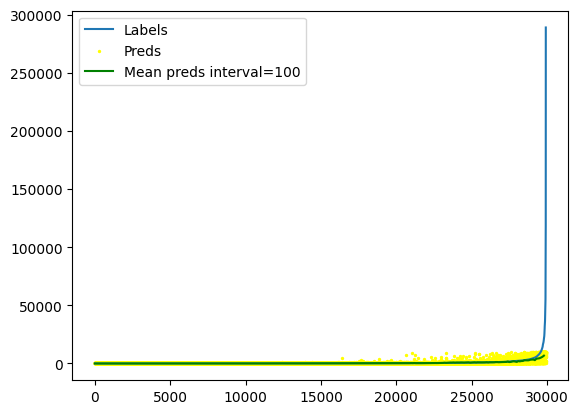

In [89]:
sorted_indices = np.argsort(fin_labels)
si = sorted_indices.tolist()
# Sort array1 in increasing order
sorted_fin_labels = fin_labels[si]

# Use the sorted indices to rearrange array2
sorted_fin_preds = fin_preds[si]

interval=100

num_intervals = len(sorted_fin_preds) // interval
mean_values = np.zeros(num_intervals)
for i in range(num_intervals):
    start_index = i * interval
    end_index = (i + 1) * interval
    interval_values = sorted_fin_preds[start_index:end_index]
    mean_values[i] = np.mean(interval_values)
x_axis_means = np.arange(0, len(sorted_fin_preds), interval)[:num_intervals]

plt.plot(sorted_fin_labels)
plt.scatter(range(len(sorted_fin_preds)),sorted_fin_preds,c='yellow',s=2)
plt.plot(x_axis_means, mean_values, linestyle='-', color='green')
plt.legend(['Labels','Preds','Mean preds interval='+str(interval)])

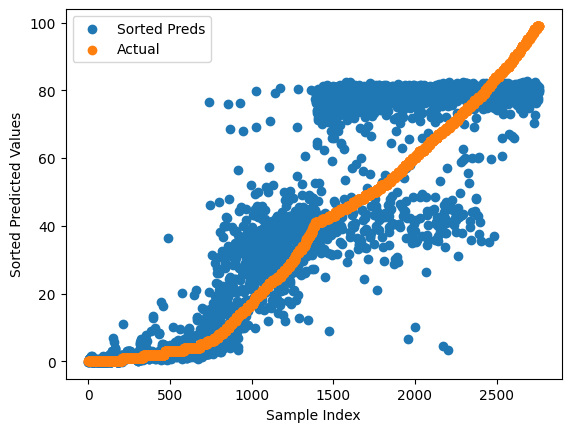

In [46]:
fin_preds = np.array(fin_preds)

# Sort predicted values in increasing order
sorted_indices = np.argsort(fin_labels).tolist()

fin_preds = fin_preds[sorted_indices]
fin_labels = fin_labels[sorted_indices]

# Create a scatter plot

plt.scatter(range(len(fin_preds)), fin_preds, label='Sorted Preds')
plt.scatter(range(len(fin_labels)), fin_labels, label='Actual')
# Add labels and legend
plt.xlabel('Sample Index')
plt.ylabel('Sorted Predicted Values')
plt.legend()

# Show the plot
plt.show()

In [39]:
sorted_indices = np.argsort(fin_labels)

In [40]:
si = sorted_indices.tolist()

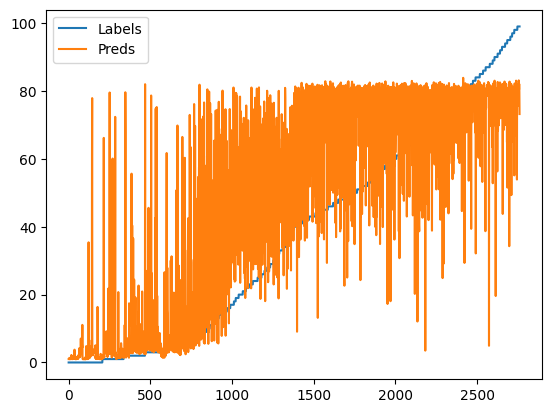

In [41]:
# Sort array1 in increasing order
sorted_fin_labels = fin_labels[si]

# Use the sorted indices to rearrange array2
sorted_fin_preds = fin_preds[si]

plt.plot(sorted_fin_labels)
plt.plot(sorted_fin_preds)
plt.legend(['Labels','Preds'])

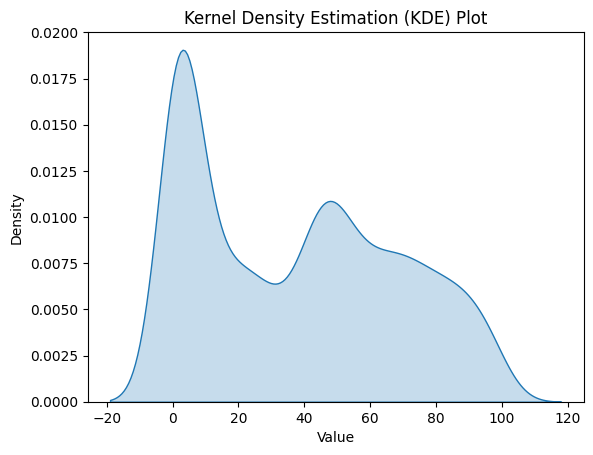

In [45]:
sns.kdeplot(sorted_fin_labels, fill=True)
plt.title("Kernel Density Estimation (KDE) Plot")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

Total Mass (area under the curve): 0.8753728129529419


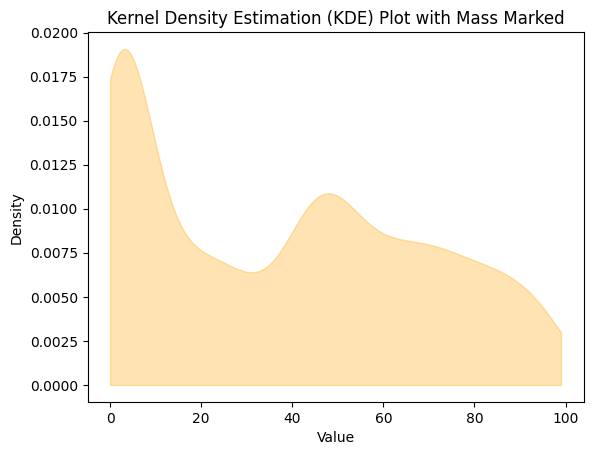

In [53]:
sample_data = sorted_fin_labels
kde = gaussian_kde(sample_data)

x_range = np.linspace(min(sample_data), max(sample_data), 1000)

mass = np.trapz(kde(x_range), x_range)

plt.fill_between(x_range, 0, kde(x_range), where=(x_range <= max(x_range)), interpolate=True, alpha=0.3, color='orange')

print("Total Mass (area under the curve):", mass)

plt.title("Kernel Density Estimation (KDE) Plot with Mass Marked")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

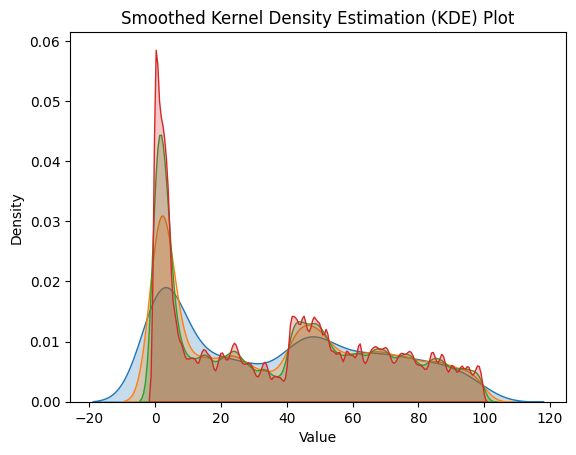

In [109]:
sample_data = sorted_fin_labels

# Create a KDE plot with a smaller bandwidth for smoothing
kde = sns.kdeplot(sample_data, fill=True, bw_adjust=1)
kde = sns.kdeplot(sample_data, fill=True, bw_adjust=0.5)
kde = sns.kdeplot(sample_data, fill=True, bw_adjust=0.25)
kde = sns.kdeplot(sample_data, fill=True, bw_adjust=0.1)

plt.title("Smoothed Kernel Density Estimation (KDE) Plot")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

## Misc

In [ ]:
model_2.eval()
val_loss = 0.0
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        val_loss += loss.item()

average_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {average_val_loss}")

Validation Loss: 130.65498633501005


In [ ]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_features, train_classes)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
preds = model_0.predict(val_features)

In [ ]:
import torch

In [ ]:
model_1 = torch.load('/content/drive/MyDrive/model_1.pth')
model_2 = torch.load('/content/drive/MyDrive/model_2.pth')
model_3 = torch.load('/content/drive/MyDrive/model_3.pth')

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1.to(device)
model_2.to(device)
model_3.to(device)

model_1.eval()
model_2.eval()
model_3.eval()

class CustomRegressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

val_texts = val_content

val_dataset = CustomRegressionDataset(val_texts, val_labels, tokenizer, max_length=128)
val_loader = DataLoader(val_dataset, batch_size=1)

val_loss = 0.0

cnt = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if val_classes[cnt] == 0:
          outputs = model_1(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss
        if val_classes[cnt] == 1:
          outputs = model_2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss
        if val_classes[cnt] == 2:
          outputs = model_3(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss

        val_loss += loss.item()
        cnt += 1
        # print(cnt)

average_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {average_val_loss}")